In [46]:
# Scripts Installation Path: 'C:\Users\Talha\AppData\Local\Programs\Python\Python312\Scripts'

# Libraries installed: 
# 1. diffusers
# 2. transformers
# 3. accelerate
# 4. hf_xet

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt


import torch, transformers, shutil, os

from diffusers          import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from transformers       import CLIPTextModel, CLIPTokenizer
from torchinfo          import summary
from PIL                import Image
from torchvision        import transforms as tfms
from tqdm.auto          import tqdm
from IPython.display    import display, clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
## Initiating tokenizer and encoder.
tokenizer    = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to(device)

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(device)

In [ ]:
# Steps to run VAE (83.65 Million Params)

# 1) Make sure input is dtype torch.float16 and on the same device as the model.
# 2) The forward pass consists of 3 steps
#    i)   posterior  = vae.encode(inputs).latent_dist --> gives a DiagnolGaussianDistribution Object which has the mean, logvar etc as its self members
#    ii)  pos_sample = posterior.sample() --> simply returns a latent representation sample by x = self.mean + self.std * epsilon (of same shape as self.mean) with 
#         latent_dim = H/8, W /8
#    iii) recon      = vae.decode(pos_sample).sample --> returns the reconstruction which is logits I believe.

# Example Usage
# >>> inputs = torch.randn(1, 3, 256, 256).to(torch.float16).to('cuda')
# >>> recon  = vae(inputs)

In [48]:
## Helper functions
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images


def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()


In [67]:
prompts = 'Black cat doing deep learning on a rusty GPU'
bs      = len(prompts) # 19
text    = text_enc(prompts) # (1, 77, 768) 
uncond  = text_enc([''] * bs, text.shape[1]) # (19, 77, 768)
emb     = torch.cat([uncond, text])          # (20, 77, 768) 

print(f'text_encoding shape: {text.shape}, uncond_text.shape: {uncond.shape}, emb.shape: {emb.shape}')  


text_encoding shape: torch.Size([1, 77, 768]), uncond_text.shape: torch.Size([44, 77, 768]), emb.shape: torch.Size([45, 77, 768])


In [72]:
# Instanting random noise which will be noised and feeded to unet along with prompt. Note see 'https://huggingface.co/CompVis/stable-diffusion-v1-4/blob/main/unet/config.json' for the config for unet in SD 1.4
dim = 512
latents = torch.randn((bs, unet.config.in_channels, dim//8, dim//8))# Initiating random noise

# Setting number of steps in scheduler
scheduler.set_timesteps(70)

# Adding noise to the latents 
latents = latents.to("cuda").half() * scheduler.init_noise_sigma
latents.shape

torch.Size([44, 4, 64, 64])

In [78]:
ts = 999.0
inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

summary(unet, input_data = [inp, ts, emb])

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Timesteps: 1, TimestepEmbedding: 1, Linear: 2, SiLU: 2, Linear: 2]

In [73]:
def prompt_2_img(prompts, g=100, seed=100, steps=70, dim=512, save_int=True):
    """
    Diffusion process to convert prompt to image
    """
    
    # Defining batch size
    bs = len(prompts) 
    
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""] * bs, text.shape[1])
    emb    = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Initiating random noise
    latents = torch.randn((bs, unet.config.in_channels, dim//8, dim//8))
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Adding noise to the latents 
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    print("Processing text prompts:", prompts)
    # Just before the loop starts:
    print("Visualizing initial latents...")
    latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
    print(f"Initial Latents Norm: {latents_norm}")

    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Inside your loop, after `latents` have been updated:
        latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
        print(f"Step {i+1}/{steps} Latents Norm: {latents_norm}")
        
        from IPython.display import display, clear_output
        if save_int and i%10==0: 
            image_path = f'steps2/la_{i:04d}.jpeg'
            latents_to_pil(latents)[0].save(image_path)
            display(latents_to_pil(latents)[0])  # Display the new image

    return latents_to_pil(latents)

Processing text prompts: ['Black cat doing deep learning on a rusty GPU']
Visualizing initial latents...
Initial Latents Norm: 1874.0


  0%|          | 0/70 [00:00<?, ?it/s]

Step 1/70 Latents Norm: 1720.0


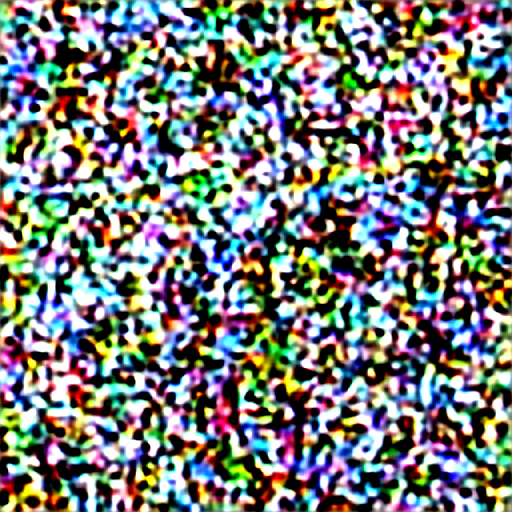

  4%|▍         | 3/70 [00:00<00:12,  5.55it/s]

Step 2/70 Latents Norm: 1598.0
Step 3/70 Latents Norm: 1471.0
Step 4/70 Latents Norm: 1462.0


 10%|█         | 7/70 [00:00<00:07,  8.56it/s]

Step 5/70 Latents Norm: 1275.0
Step 6/70 Latents Norm: 1221.0
Step 7/70 Latents Norm: 1108.0


 13%|█▎        | 9/70 [00:01<00:06,  9.27it/s]

Step 8/70 Latents Norm: 1038.0
Step 9/70 Latents Norm: 965.0
Step 10/70 Latents Norm: 903.0
Step 11/70 Latents Norm: 847.5


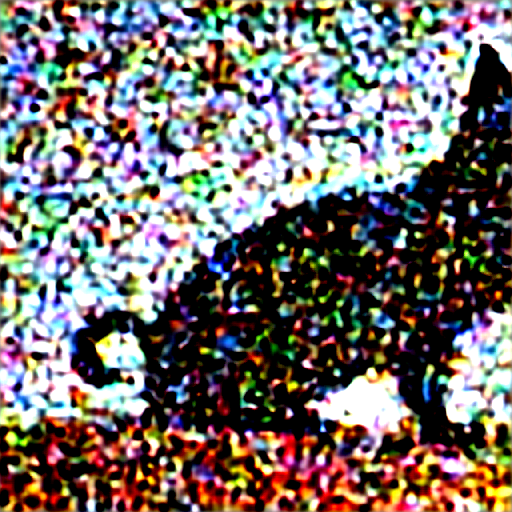

 19%|█▊        | 13/70 [00:01<00:07,  7.24it/s]

Step 12/70 Latents Norm: 799.0
Step 13/70 Latents Norm: 755.0
Step 14/70 Latents Norm: 716.5


 24%|██▍       | 17/70 [00:02<00:06,  8.79it/s]

Step 15/70 Latents Norm: 681.5
Step 16/70 Latents Norm: 650.5
Step 17/70 Latents Norm: 622.5


 27%|██▋       | 19/70 [00:02<00:05,  9.31it/s]

Step 18/70 Latents Norm: 597.5
Step 19/70 Latents Norm: 575.5
Step 20/70 Latents Norm: 556.0
Step 21/70 Latents Norm: 538.0


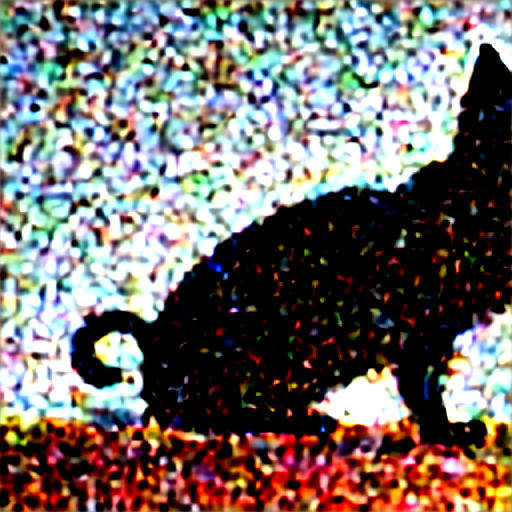

 33%|███▎      | 23/70 [00:03<00:06,  7.46it/s]

Step 22/70 Latents Norm: 522.0
Step 23/70 Latents Norm: 508.0
Step 24/70 Latents Norm: 494.5


 39%|███▊      | 27/70 [00:03<00:04,  8.87it/s]

Step 25/70 Latents Norm: 482.75
Step 26/70 Latents Norm: 470.5
Step 27/70 Latents Norm: 460.5


 41%|████▏     | 29/70 [00:03<00:04,  9.35it/s]

Step 28/70 Latents Norm: 450.25
Step 29/70 Latents Norm: 441.5
Step 30/70 Latents Norm: 433.0
Step 31/70 Latents Norm: 425.25


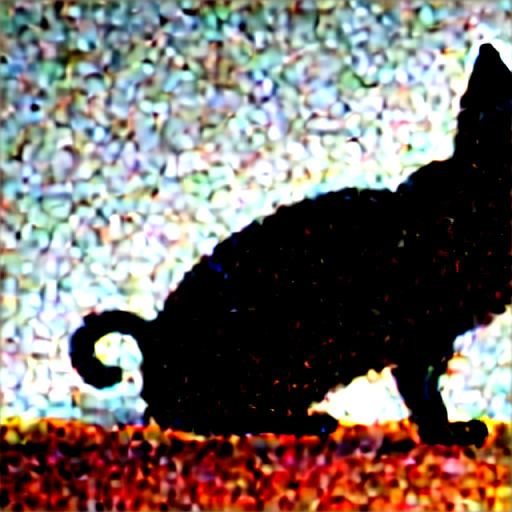

 47%|████▋     | 33/70 [00:04<00:04,  7.50it/s]

Step 32/70 Latents Norm: 418.0
Step 33/70 Latents Norm: 411.25
Step 34/70 Latents Norm: 405.25


 53%|█████▎    | 37/70 [00:04<00:03,  8.82it/s]

Step 35/70 Latents Norm: 399.5
Step 36/70 Latents Norm: 394.0
Step 37/70 Latents Norm: 389.25


 56%|█████▌    | 39/70 [00:04<00:03,  9.29it/s]

Step 38/70 Latents Norm: 384.75
Step 39/70 Latents Norm: 380.75
Step 40/70 Latents Norm: 376.75
Step 41/70 Latents Norm: 373.25


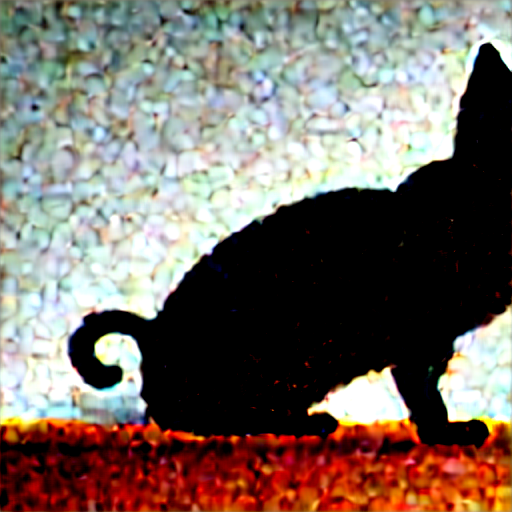

 61%|██████▏   | 43/70 [00:05<00:03,  7.33it/s]

Step 42/70 Latents Norm: 370.0
Step 43/70 Latents Norm: 367.0
Step 44/70 Latents Norm: 364.25


 67%|██████▋   | 47/70 [00:06<00:02,  8.74it/s]

Step 45/70 Latents Norm: 361.75
Step 46/70 Latents Norm: 359.5
Step 47/70 Latents Norm: 357.5


 70%|███████   | 49/70 [00:06<00:02,  9.22it/s]

Step 48/70 Latents Norm: 355.5
Step 49/70 Latents Norm: 354.0
Step 50/70 Latents Norm: 352.5
Step 51/70 Latents Norm: 351.25


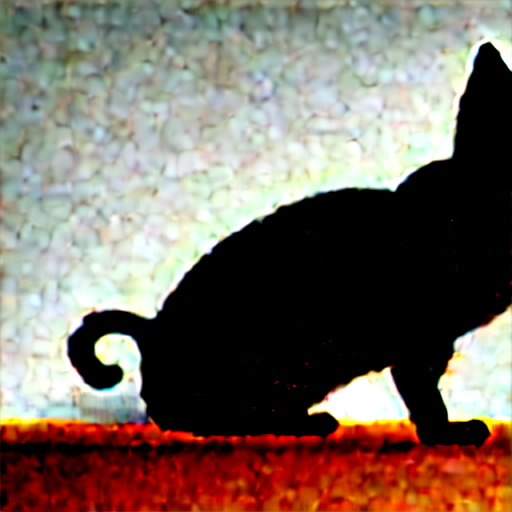

 76%|███████▌  | 53/70 [00:06<00:02,  7.20it/s]

Step 52/70 Latents Norm: 350.0
Step 53/70 Latents Norm: 349.0
Step 54/70 Latents Norm: 348.25


 81%|████████▏ | 57/70 [00:07<00:01,  8.62it/s]

Step 55/70 Latents Norm: 347.5
Step 56/70 Latents Norm: 346.75
Step 57/70 Latents Norm: 346.0


 84%|████████▍ | 59/70 [00:07<00:01,  9.13it/s]

Step 58/70 Latents Norm: 345.25
Step 59/70 Latents Norm: 344.5
Step 60/70 Latents Norm: 343.75
Step 61/70 Latents Norm: 342.75


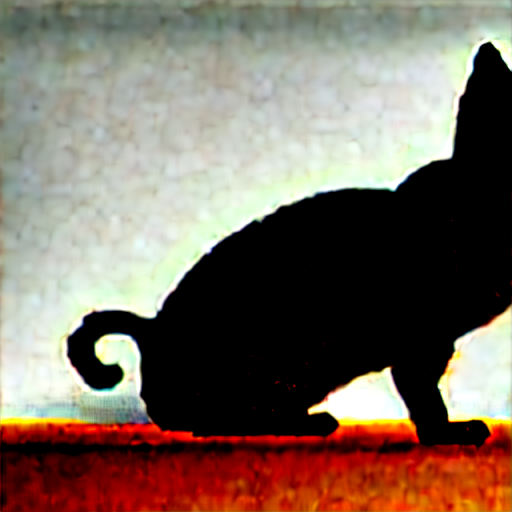

 90%|█████████ | 63/70 [00:08<00:00,  7.16it/s]

Step 62/70 Latents Norm: 342.0
Step 63/70 Latents Norm: 341.0
Step 64/70 Latents Norm: 339.75


 96%|█████████▌| 67/70 [00:08<00:00,  8.61it/s]

Step 65/70 Latents Norm: 338.5
Step 66/70 Latents Norm: 337.5
Step 67/70 Latents Norm: 336.25


100%|██████████| 70/70 [00:08<00:00,  7.86it/s]

Step 68/70 Latents Norm: 335.25
Step 69/70 Latents Norm: 346.75
Step 70/70 Latents Norm: 345.5


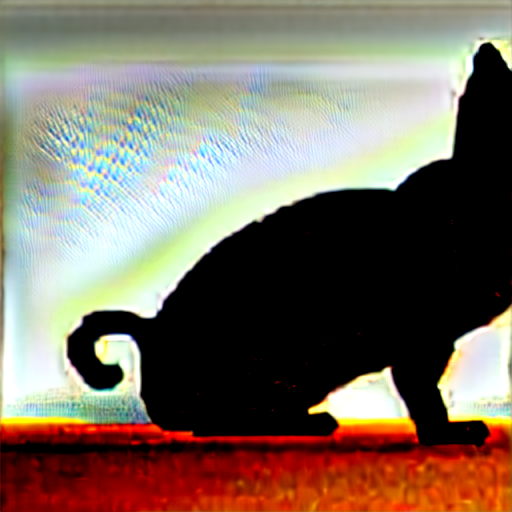

In [74]:
images = prompt_2_img([prompts], save_int=True)
for img in images:display(img)
